
# Tech Challenge — Fase 1
**Tema:** Classificação de Doença Cardíaca (Cleveland Dataset) - Suporte ao diagnóstico, capaz de ajudar médicos e equipes clínicas na análise inicial de exames e no processamento de dados médicos.

> _“Se o pronto atendimento está cheio, qual paciente deve ser priorizado para avaliação cardiológica?”_  
O objetivo é estimar a probabilidade de **doença cardíaca** (0/1) para apoiar a **triagem** — não substitui avaliação médica.

## Roteiro
1. Preparação do ambiente  
2. Dados e visão rápida (download, leitura, inspeção)  
3. Pré-processamento (filtro etário 40–70 e seleção de variáveis)  
4. Treino/validação com **Regressão Logística**  
5. Avaliação (relatório, matriz de confusão, coeficientes)  
6. Exportação do modelo e scaler  
7. **KNN** como experimento à parte  
8. Conclusões




## 1. Preparação do ambiente
Requisitos principais: `pandas`, `numpy`, `scikit-learn`, `matplotlib`, `seaborn`, `joblib`, `kagglehub`.


In [1]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import kagglehub

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score
)

np.random.seed(42)
plt.rcParams['figure.figsize'] = (8, 4)
print("Ambiente preparado.")

Ambiente preparado.



## 2. Dados (Cleveland — Kaggle/UCI) e visão rápida
Estamos utilizando o dataset público **Cleveland Heart Disease**.  
O alvo é `condition` (0 = sem doença, 1 = com doença). Para manter compatibilidade com a API do projeto, são utilizadas **cinco variáveis**: `thal`, `ca`, `oldpeak`, `exang`, `cp`.

Abaixo, o download/leitura e algumas visualizações exploratórias equivalentes ao script `analise_data.py`.


Shape bruto: (297, 14)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,condition
0,69,1,0,160,234,1,2,131,0,0.1,1,1,0,0
1,69,0,0,140,239,0,0,151,0,1.8,0,2,0,0
2,66,0,0,150,226,0,0,114,0,2.6,2,0,0,0
3,65,1,0,138,282,1,2,174,0,1.4,1,1,0,1
4,64,1,0,110,211,0,2,144,1,1.8,1,0,0,0


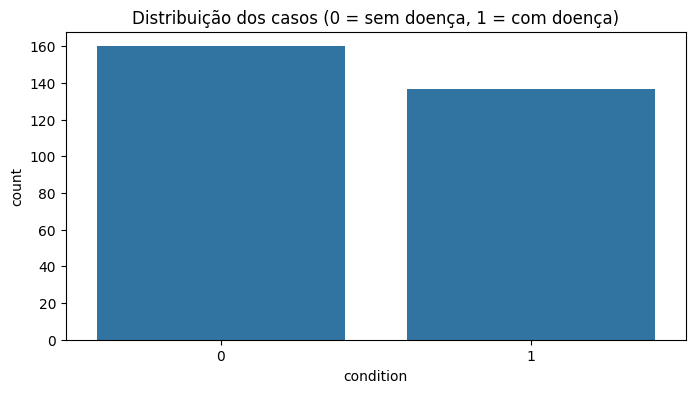

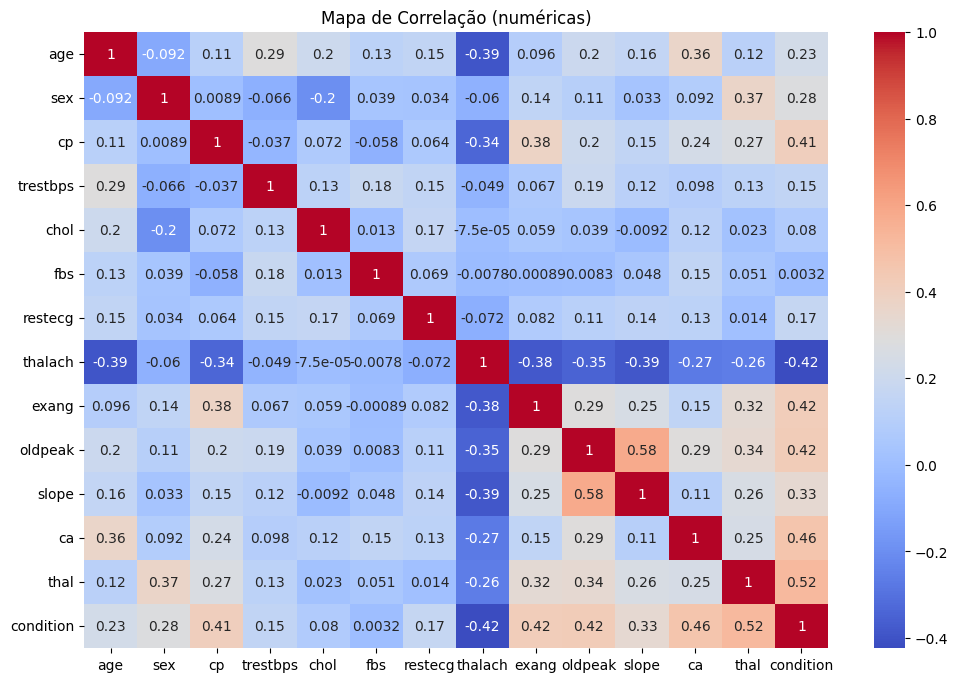

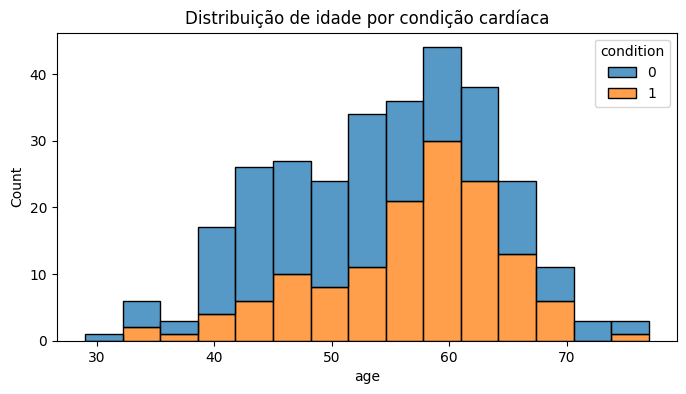

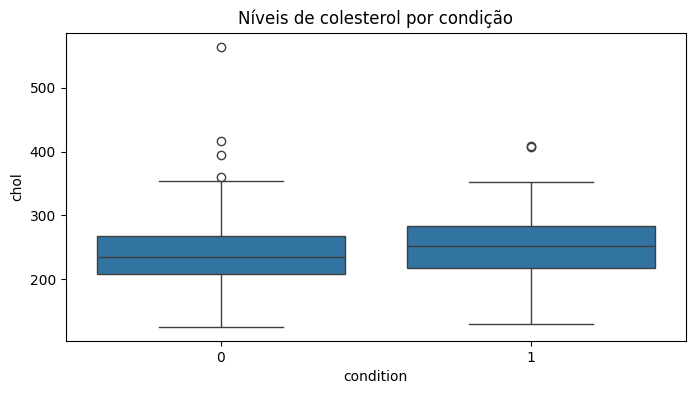

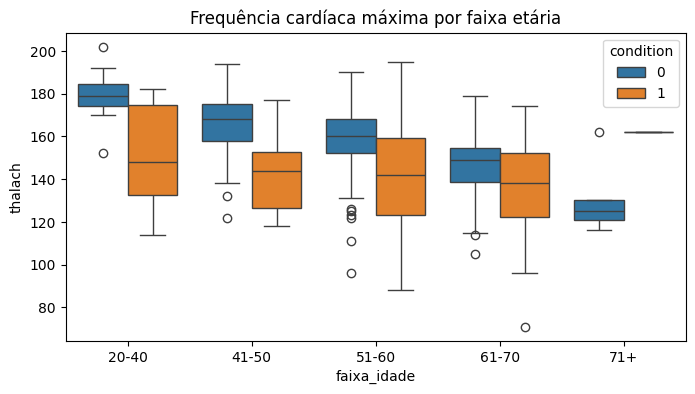

In [2]:

# Download e leitura
path = kagglehub.dataset_download("cherngs/heart-disease-cleveland-uci")
csv_path = f"{path}/heart_cleveland_upload.csv"
df = pd.read_csv(csv_path)

print("Shape bruto:", df.shape)
display(df.head())

# EDA rápida (analise_data.py)
sns.countplot(data=df, x='condition')
plt.title('Distribuição dos casos (0 = sem doença, 1 = com doença)')
plt.show()

plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title('Mapa de Correlação (numéricas)')
plt.show()

sns.histplot(data=df, x='age', hue='condition', multiple='stack', bins=15)
plt.title('Distribuição de idade por condição cardíaca')
plt.show()

sns.boxplot(data=df, x='condition', y='chol')
plt.title('Níveis de colesterol por condição')
plt.show()

df['faixa_idade'] = pd.cut(df['age'], bins=[20, 40, 50, 60, 70, 100], labels=['20-40', '41-50', '51-60', '61-70', '71+'])
sns.boxplot(data=df, x='faixa_idade', y='thalach', hue='condition')
plt.title('Frequência cardíaca máxima por faixa etária')
plt.show()


## 3. Pré-processamento

- **Filtro etário 40–70**: reduz extremos que podem distorcer métricas;
- **Features**: `['thal','ca','oldpeak','exang','cp']`


In [3]:

# Contagens informativas
count_menor_que_40 = df[df['age'] < 40].shape[0]
count_maior_que_70 = df[df['age'] > 70].shape[0]
print(f"Qtde com idade < 40: {count_menor_que_40}")
print(f"Qtde com idade > 70: {count_maior_que_70}")

# Filtro 40–70
df_filt = df[(df['age'] >= 40) & (df['age'] <= 70)].copy()

FEATURES = ['thal','ca','oldpeak','exang','cp']
TARGET = 'condition'

X = df_filt[FEATURES]
y = df_filt[TARGET]

print("Shapes pós-filtro -> X:", X.shape, "| y:", y.shape)

Qtde com idade < 40: 14
Qtde com idade > 70: 6
Shapes pós-filtro -> X: (277, 5) | y: (277,)



## 4. Modelagem — **Regressão Logística**
Usa-se `StandardScaler` **separado** do modelo e validação com `cross_val_score` (F1), conforme o código do `app.py`.  
> Observação: mantém-se o padrão do script (sem `Pipeline` para o treino final, pois a API carrega **modelo** e **scaler** separadamente).


In [4]:

# Split (como no app.py: sem estratificar)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Padronização separada
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# Modelo
model = LogisticRegression(max_iter=1000)
model.fit(X_train_scaled, y_train)

# Predições
y_pred = model.predict(X_test_scaled)

# Validação cruzada simples (como no app.py)
scores = cross_val_score(model, X, y, cv=5, scoring='f1')
print("\nF1 médio (cross-validation):", scores.mean())


F1 médio (cross-validation): 0.7218866382750264



## 5. Avaliação
Relatório de classificação, acurácia, matriz de confusão e **coeficientes** (importância relativa das variáveis na Regressão Logística).



🔍 Acurácia: 0.8214285714285714

📊 Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.77      0.89      0.83        27
           1       0.88      0.76      0.81        29

    accuracy                           0.82        56
   macro avg       0.83      0.82      0.82        56
weighted avg       0.83      0.82      0.82        56

[[24  3]
 [ 7 22]]


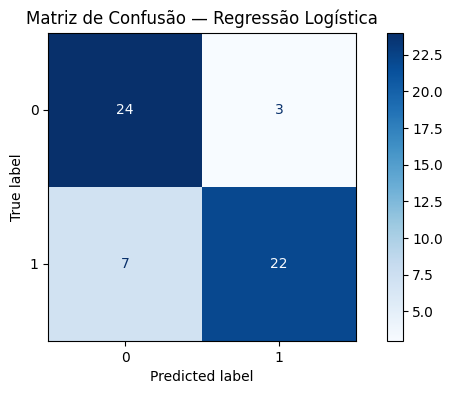


Coeficientes (importância das variáveis):
  Variável  Coeficiente
1       ca     0.910638
2  oldpeak     0.767980
0     thal     0.689952
3    exang     0.492780
4       cp     0.429692


In [5]:

print("\n🔍 Acurácia:", accuracy_score(y_test, y_pred))
print("\n📊 Relatório de Classificação:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
print(cm)
ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap="Blues")
plt.title("Matriz de Confusão — Regressão Logística")
plt.show()

coef_df = pd.DataFrame({'Variável': X.columns, 'Coeficiente': model.coef_[0]})\
    .sort_values(by='Coeficiente', key=np.abs, ascending=False)
print("\nCoeficientes (importância das variáveis):")
print(coef_df)


## 6. Exportação do modelo e scaler
Mantêm-se **dois arquivos** (compatíveis com a API):  
- `app/model/modelo.pkl` (modelo)  
- `app/model/scaler.pkl` (scaler)


In [6]:

import os
os.makedirs("app/model", exist_ok=True)
joblib.dump(model, "app/model/modelo.pkl")
joblib.dump(scaler, "app/model/scaler.pkl")
print("Artefatos salvos em app/model/ (modelo.pkl, scaler.pkl)")

Artefatos salvos em app/model/ (modelo.pkl, scaler.pkl)



## 7. (Opcional) KNN — experimento à parte
Aqui é reproduzido o script `analise_knn.py`:  
- mesmas **5 features** e **filtro 40–70**;  
- *split* **estratificado**;  
- **padronização** dentro de `Pipeline`;  
- *Grid Search* por **F1** em validação cruzada.


In [8]:

# Recarrega dados do Kaggle para isolar o experimento
path_knn = kagglehub.dataset_download("cherngs/heart-disease-cleveland-uci")
csv_path_knn = f"{path_knn}/heart_cleveland_upload.csv"
df_knn = pd.read_csv(csv_path_knn)

# Pré-processamento
df_knn = df_knn[(df_knn['age'] >= 40) & (df_knn['age'] <= 70)].copy()
X_knn = df_knn[FEATURES].copy()
y_knn = df_knn[TARGET].copy()

# Split estratificado
X_train_k, X_test_k, y_train_k, y_test_k = train_test_split(
    X_knn, y_knn, test_size=0.20, random_state=42, stratify=y_knn
)

# Pipeline + busca de hiperparâmetros
pipe = Pipeline([("scaler", StandardScaler()), ("clf", KNeighborsClassifier())])
param_grid = {"clf__n_neighbors": [3, 5, 7, 9, 11],
              "clf__weights": ["uniform", "distance"],
              "clf__p": [1, 2]}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

gs = GridSearchCV(estimator=pipe, param_grid=param_grid, scoring="f1",
                  cv=cv, n_jobs=-1, refit=True, verbose=0)
gs.fit(X_train_k, y_train_k)

print("Melhores hiperparâmetros (CV por F1):", gs.best_params_)
print("Melhor F1 (validação):", round(gs.best_score_, 3))

best_knn = gs.best_estimator_
y_pred_k = best_knn.predict(X_test_k)

print("\n=== Desempenho no TESTE (KNN) ===")
print("Accuracy:", round(accuracy_score(y_test_k, y_pred_k), 3))
print("F1      :", round(f1_score(y_test_k, y_pred_k), 3))
print("\nClassification report:\n", classification_report(y_test_k, y_pred_k, digits=3))
print("Matriz de confusão:\n", confusion_matrix(y_test_k, y_pred_k))

Melhores hiperparâmetros (CV por F1): {'clf__n_neighbors': 11, 'clf__p': 1, 'clf__weights': 'uniform'}
Melhor F1 (validação): 0.821

=== Desempenho no TESTE (KNN) ===
Accuracy: 0.75
F1      : 0.72

Classification report:
               precision    recall  f1-score   support

           0      0.727     0.828     0.774        29
           1      0.783     0.667     0.720        27

    accuracy                          0.750        56
   macro avg      0.755     0.747     0.747        56
weighted avg      0.754     0.750     0.748        56

Matriz de confusão:
 [[24  5]
 [ 9 18]]



## 8. Conclusões
- O fluxo mantém as escolhas do código atual: **Regressão Logística** com `StandardScaler` separado, validação por `cross_val_score` e exportação em **dois artefatos** (`modelo.pkl` e `scaler.pkl`).  
- O filtro **40–70** e o uso das **5 features** (`thal`, `ca`, `oldpeak`, `exang`, `cp`) mantêm compatibilidade com a API e evitam distorções por extremos.  
- O experimento com **KNN** foi estruturado de forma justa (mesmas features, *split* estratificado, padronização e *grid search*), oferecendo uma comparação adicional.  
- Em contexto clínico, costuma-se valorizar **Recall** para casos positivos (evitar falsos negativos). Ajuste de limiar ou `class_weight` pode ser considerado em versões futuras.
